In [1]:
# the building we want to run
building_id = 3
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 40
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "rbf-net"
number_of_opt_evaluations = 100
run_i = 3
iteration = 68
building_id = 2
price = 106


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,building_id,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,building_id,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,building_id,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
import time
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    try:
      if not os.path.exists(directory):
          os.makedirs(directory)
    except:
      time.sleep(10)
      if not os.path.exists(directory):
          os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}-{}/".format(opt_method,price,building_id,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /cvmfs/soft.computecanada.ca/easybuild/software/2020/Core/energyplus/9.3.0/


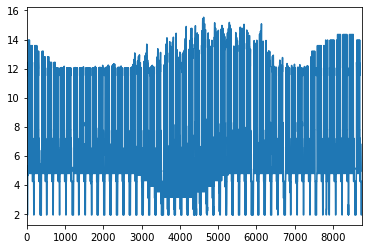

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.56
14.35221199000051


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

energy_plus/output_energy_plus/rbf-net-106-2-3/eplusout.sql
Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.35886812210083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.0595386028289795 sec


ERROR:root:Finished Generation of Irradiance


0.0


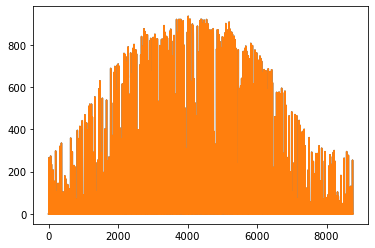

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,845 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.56


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


{'name': 'gurobi', 'options': None}
Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.012213468551636 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.074638843536377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.180809736251831 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


INFO:root:Constraint: calc_investment_cost


INFO:root:Constraint: calc_maintenance_cost


INFO:root:Constraint: calc_operating_cost


INFO:root:Constraint: calc_total_carbon


INFO:root:Constraint: calc_total_cost


INFO:root:Constraint: constrain_max_energy


INFO:root:Constraint: daily_c_lower_medlar


INFO:root:Constraint: daily_c_lower_small


INFO:root:Constraint: daily_c_upper_medlar


INFO:root:Constraint: daily_c_upper_small


INFO:root:Constraint: energy_balance


INFO:root:Constraint: force_install


INFO:root:Constraint: large_lower


INFO:root:Constraint: large_operating_export_lower


INFO:root:Constraint: large_operating_export_upper


INFO:root:Constraint: large_operating_import_lower


INFO:root:Constraint: large_operating_import_upper


INFO:root:Constraint: large_upper


INFO:root:Constraint: max_carbon_level


INFO:root:Constraint: max_track_constraint


INFO:root:Constraint: med_operating_export_lower


INFO:root:Constraint: med_operating_export_upper


INFO:root:Constraint: med_operating_import_lower


INFO:root:Constraint: med_operating_import_upper


INFO:root:Constraint: medium_lower


INFO:root:Constraint: medium_upper


INFO:root:Constraint: monthly_bill_lower


INFO:root:Constraint: monthly_bill_upper


INFO:root:Constraint: monthly_export_constraint


INFO:root:Constraint: monthly_import_constraint


INFO:root:Constraint: net_metering_constraint


INFO:root:Constraint: roof_tech_area_below_max


INFO:root:Constraint: roof_tech_area_definition


INFO:root:Constraint: roof_tech_cap_max


INFO:root:Constraint: small_demand_charge_constraint


INFO:root:Constraint: small_operating_export_lower


INFO:root:Constraint: small_operating_export_upper


INFO:root:Constraint: small_operating_import_lower


INFO:root:Constraint: small_operating_import_upper


INFO:root:Constraint: storage_balance


INFO:root:Constraint: storage_charge_rate


INFO:root:Constraint: storage_discharge_rate


INFO:root:Constraint: storage_input_positive


INFO:root:Constraint: storage_is_installed


INFO:root:Constraint: storage_is_installed_2


INFO:root:Constraint: storage_level_above_minimum


INFO:root:Constraint: storage_level_below_capacity


INFO:root:Constraint: storage_level_positive


INFO:root:Constraint: storage_looping


INFO:root:Constraint: storage_output_positive


INFO:root:Constraint: tech_export_positive


INFO:root:Constraint: tech_import_positive


INFO:root:Constraint: tech_input_below_capacity


INFO:root:Constraint: tech_input_positive


INFO:root:Constraint: tech_is_installed


INFO:root:Constraint: tech_is_installed_2


INFO:root:Constraint: tech_is_on


INFO:root:Constraint: tech_is_on_2


INFO:root:Constraint: tech_part_loads


INFO:root:Constraint: total_export_value_constraint


INFO:root:Constraint: total_import_value_constraint


INFO:root:Constraint: total_roof_area_definition


INFO:root:Constraint: track_above_150_constraint_lower


INFO:root:Constraint: track_above_150_constraint_upper


INFO:root:Constraint: track_above_35_constraint_lower


INFO:root:Constraint: track_above_35_constraint_upper


INFO:root:Constraint: track_above_550_constraint_lower


INFO:root:Constraint: track_above_550_constraint_upper


INFO:root:Constraint: track_any_above_150_constraint_lower


INFO:root:Constraint: track_any_above_150_constraint_upper


INFO:root:Constraint: track_any_above_35_constraint_lower


INFO:root:Constraint: track_any_above_35_constraint_upper


INFO:root:Constraint: track_or_constraint_lower


INFO:root:Constraint: track_or_constraint_upper


INFO:root:Constraint: track_or_constraint_upper2


INFO:root:Constraint List: capacity_bounds


ERROR:ga_logger:Recompiled the model in 261 s


ERROR:ga_logger:Starting solver


None


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [307.53518498812736, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.5574048188814


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


Total Electricity Imported from the grid 50,271 kWh
At a cost of $ 0.1253 /kWh
Total Cost of the system: $ 3,188 per year


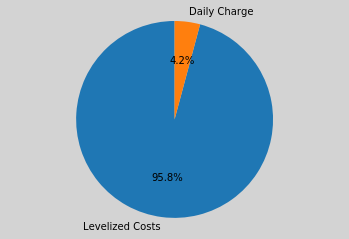

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings={
                    'name': 'gurobi',
                    'options':None
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=1.5,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

50270.728631185906

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr     3953.588272
Aug     4232.535574
Dec     4728.407874
Feb     4220.904101
Jan     4695.625513
Jul     3596.797122
Jun     3505.544383
Mar     4553.295110
May     3930.927926
Nov     4284.410932
Oct     4521.675077
Sep     4047.016748
monthly_import    50270.728631
dtype: float64
50270.728631185906
     monthly_export
Apr     6047.180913
Aug     6614.423308
Dec      804.969294
Feb     2251.160819
Jan      895.761370
Jul     7708.016021
Jun     6371.405780
Mar     3649.482470
May     7091.115573
Nov      925.105855
Oct     2596.898286
Sep     5315.108943
monthly_export    50270.628631
dtype: float64
50270.62863118734
133.0424999999616


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.0424999999616

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng           1.0
Grid               1.0
Invertor           1.0
PV0                1.0
PV1                0.0
PV2                0.0

In [23]:
my_model.solveResults['solution']['any_above_35']

0.0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0.0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings,
                         force_install=False)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:The number of evaluations is 100


[90.  90.  90.   1.   1.   1.   0.2  0.2  0.2] [265.  265.  265.   56.   56.   56.    0.9   0.9   0.9] ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


ERROR:ga_logger:panel values: (158.07838656145674, 152.33462638858475, 259.2329891123764, 22.258648632375763, 6.41149875101028, 36.47066956218197, 0.3730019441355895, 0.39802586361368053, 0.39379155414147904)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 22.3
                                           and a gcr of 0.373


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.284473896026611 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 6.4
                                           and a gcr of 0.398


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.050297498703003 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 36.5
                                           and a gcr of 0.394


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.115540266036987 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 267 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [223.33927115380598, 0.0, 0.0]


ERROR:ga_logger:Cost: 4295.992152452291


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


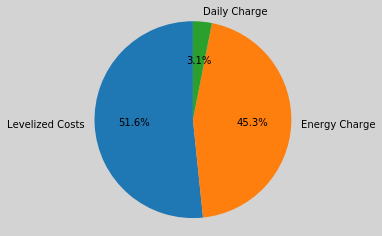

ERROR:ga_logger:panel values: (169.0904840978588, 225.07703448505194, 213.85220159722437, 25.551124903402755, 55.77948671254174, 18.06286963085258, 0.7483097817709912, 0.5822739546110305, 0.22923381983325997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 25.6
                                           and a gcr of 0.748


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.3599770069122314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 55.8
                                           and a gcr of 0.582


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.333066463470459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 18.1
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.225394010543823 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  25 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 289 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [246.5534749972578, 0.0, 61.72835562612834]


ERROR:ga_logger:Cost: 3194.9732382661177


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


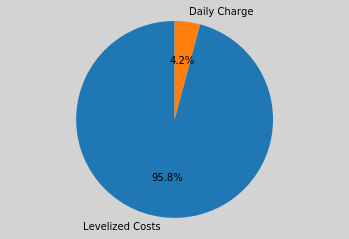

ERROR:ga_logger:panel values: (124.49182272503039, 98.373668620588, 169.74527093336766, 55.92724909903765, 29.29832879001459, 24.63049626436653, 0.7843049929283472, 0.888870132430456, 0.6301772168027447)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 124
                                           a tilt of 55.9
                                           and a gcr of 0.784


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.141886472702026 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 98
                                           a tilt of 29.3
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.149451017379761 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 24.6
                                           and a gcr of 0.630


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.169074296951294 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 278 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 301.69944254491173]


ERROR:ga_logger:Cost: 3129.595644235861


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


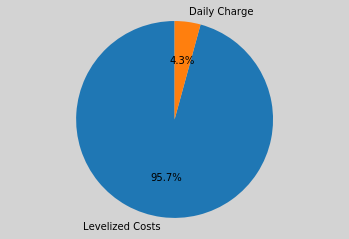

ERROR:ga_logger:panel values: (206.18277553971, 167.09393118189968, 105.42438358885376, 10.77003210139941, 16.33774125955986, 2.234787655250585, 0.22660262371877857, 0.7395802843020789, 0.8765170105681668)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 10.8
                                           and a gcr of 0.227


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.500200271606445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 16.3
                                           and a gcr of 0.740


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.1929919719696045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 2.2
                                           and a gcr of 0.877


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.019615888595581 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 275 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 310.0255962352325, 0.0]


ERROR:ga_logger:Cost: 3212.2926601837466


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


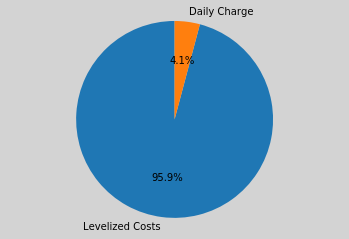

ERROR:ga_logger:panel values: (256.3538683933941, 263.434520326129, 136.66301121385072, 40.219536209225254, 35.79751445019604, 53.31500111577951, 0.5004473401567926, 0.3395302856212262, 0.5154400175747362)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 40.2
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.513716220855713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 35.8
                                           and a gcr of 0.340


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.384472608566284 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 53.3
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.345072507858276 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 279 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 308.6257314699446]


ERROR:ga_logger:Cost: 3983.5386405395184


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


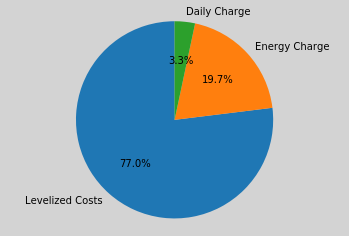

ERROR:ga_logger:panel values: (177.5, 177.5, 177.5, 28.5, 28.5, 28.5, 0.5499999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.351081848144531 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.115591526031494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.175654649734497 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 271 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.16115923082754]


ERROR:ga_logger:Cost: 3084.5205097866624


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


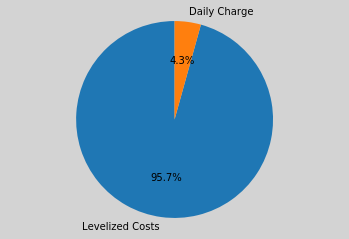

ERROR:ga_logger:panel values: (264.0742001753892, 92.66533345562902, 91.55376248531172, 55.783949765138146, 1.5720924922389847, 1.57896737149001, 0.20962826447464308, 0.2102751041289474, 0.2028548449302274)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 55.8
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.37709379196167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 1.6
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.06440806388855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 1.6
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.836267709732056 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 271 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 125.90467485849877, 0.0]


ERROR:ga_logger:Cost: 6223.5590597667215


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


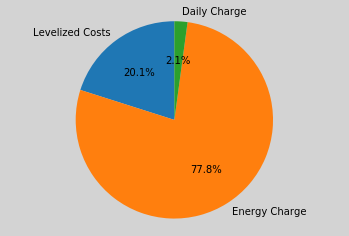

ERROR:ga_logger:panel values: (90.71139103068732, 264.0990921976561, 92.31758685005623, 54.559929741819666, 1.6737175717887762, 55.92024513404957, 0.20003378906799074, 0.8993036407939243, 0.2057959680674954)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 54.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.317279815673828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 1.7
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.02229118347168 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 55.9
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.694360971450806 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 263 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 336.3506616316857, 0.0]


ERROR:ga_logger:Cost: 3473.758456627306


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


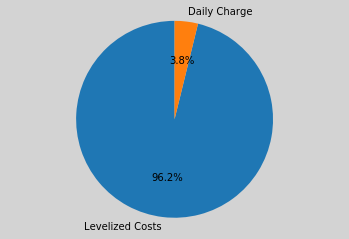

ERROR:ga_logger:panel values: (264.1901249401791, 90.51217881972347, 264.1647998060371, 54.77247801895446, 52.95679109201048, 55.502070169841794, 0.20350684174519335, 0.8928572325852611, 0.21317769105980622)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 54.8
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.447389125823975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 53.0
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.178286552429199 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 55.5
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.635659456253052 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 266 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 524.6758751452537, 2.3715506652307226]


ERROR:ga_logger:Cost: 5367.796881243146


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


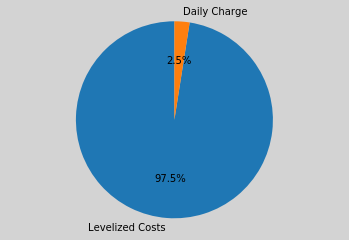

ERROR:ga_logger:panel values: (263.6365957369903, 264.9184726759859, 164.96550538515362, 49.093015275982125, 27.176647011593012, 44.28389936512334, 0.6076283647000025, 0.4508788601968473, 0.6251610313650982)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 49.1
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.407824993133545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 27.2
                                           and a gcr of 0.451


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.670504808425903 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 44.3
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.469174146652222 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 263 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.68267089534737]


ERROR:ga_logger:Cost: 3248.6154794633103


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


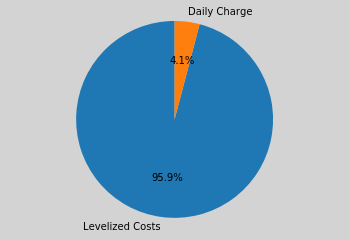

ERROR:ga_logger:panel values: (228.153916632049, 263.2108666457001, 165.37230644587456, 49.10146343665777, 44.80338074441856, 44.48985346428873, 0.3862691876467942, 0.2297599003785316, 0.6210568010489265)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 49.1
                                           and a gcr of 0.386


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.4935526847839355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 44.8
                                           and a gcr of 0.230


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.409390211105347 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 44.5
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.377712726593018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 262 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.43862637950883]


ERROR:ga_logger:Cost: 3246.191580660251


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


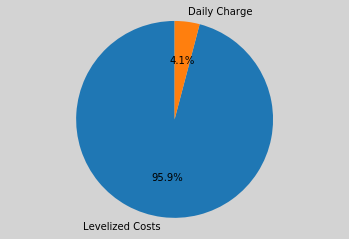

ERROR:ga_logger:panel values: (264.99999999979065, 90.00000000002585, 90.00000000002798, 1.000000000005136, 1.0000000000325426, 55.99999999999468, 0.8999999999997752, 0.2000000000001321, 0.20000000000019036)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.691186904907227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.483003616333008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.3373448848724365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  19 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 259 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [278.28236219268473, 57.91181130435412, 0.0]


ERROR:ga_logger:Cost: 3472.2041850850464


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


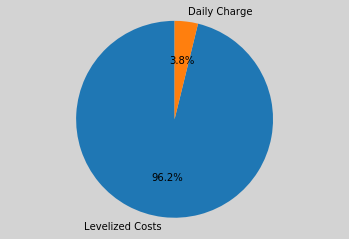

ERROR:ga_logger:panel values: (106.39715024953985, 264.33976763988295, 92.86262942418276, 1.1031629093118296, 1.4372564585346694, 55.34539098309351, 0.20804117825214213, 0.20958723627220938, 0.21737476375133596)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 106
                                           a tilt of 1.1
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.519375324249268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 1.4
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.62843132019043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 55.3
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.42441463470459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 263 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 125.49280594412684, 0.0]


ERROR:ga_logger:Cost: 6235.626517768951


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


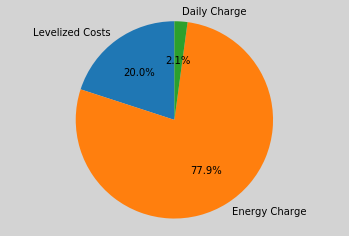

ERROR:ga_logger:panel values: (260.9766875235315, 95.78977182436363, 149.3779794166795, 1.5022438920805539, 1.3273650304495035, 55.014775929195295, 0.21069942386376334, 0.2040969017017398, 0.8782779037254194)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 1.5
                                           and a gcr of 0.211


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.934518337249756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 1.3
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.330368995666504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 55.0
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.572652816772461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 269 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [49.96858795529168, 0.0, 317.5904655967827]


ERROR:ga_logger:Cost: 3783.7264861759513


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


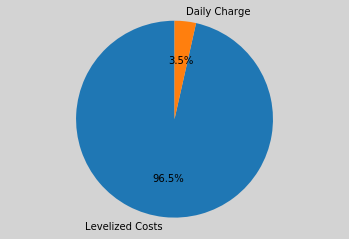

ERROR:ga_logger:panel values: (260.04886056192277, 95.41651231110089, 257.96280058396417, 1.4768449390763236, 1.216293704300543, 3.349422693262682, 0.21584168606635878, 0.20432086230283555, 0.20095897196941503)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 1.5
                                           and a gcr of 0.216


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.075019359588623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 1.2
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.911758661270142 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 3.3
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.457787990570068 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 270 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [129.2377308177775, 0.0, 0.0]


ERROR:ga_logger:Cost: 6183.588990926078


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


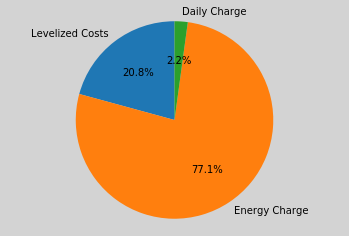

ERROR:ga_logger:panel values: (258.7432857128969, 262.97391365862, 133.78731928673864, 38.702106150990545, 35.69766467107407, 54.588604578433305, 0.5001858930109373, 0.3238830226573317, 0.47818556764190007)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 259
                                           a tilt of 38.7
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.445446252822876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 35.7
                                           and a gcr of 0.324


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.392480134963989 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 134
                                           a tilt of 54.6
                                           and a gcr of 0.478


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.317777156829834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 277 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 286.31919439760253]


ERROR:ga_logger:Cost: 4314.94206994151


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


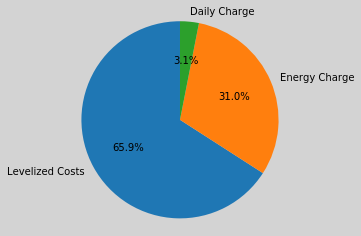

ERROR:ga_logger:panel values: (255.9577434291239, 264.0202971824524, 134.79205512943966, 40.08007125407249, 36.04608018386265, 53.869007473458915, 0.5023608191294944, 0.3341888785979144, 0.5054874818449007)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 40.1
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.6586573123931885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 36.0
                                           and a gcr of 0.334


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.151491403579712 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 53.9
                                           and a gcr of 0.505


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.177725076675415 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 278 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 302.6665344453153]


ERROR:ga_logger:Cost: 4110.805971878474


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


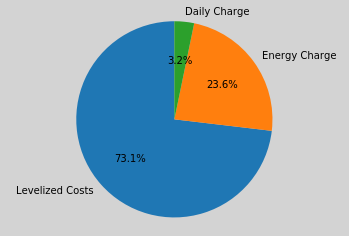

ERROR:ga_logger:panel values: (264.4858437955993, 260.51691986157243, 138.0439812224108, 36.95855706773907, 34.2998278925544, 54.53216454842013, 0.4816095521279795, 0.3312765858458315, 0.4773067755985533)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 37.0
                                           and a gcr of 0.482


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.082259893417358 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 34.3
                                           and a gcr of 0.331


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.452377080917358 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 138
                                           a tilt of 54.5
                                           and a gcr of 0.477


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.4351112842559814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 286 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [5.475266699789226e-14, 0.0, 285.7930073957476]


ERROR:ga_logger:Cost: 4218.14053277479


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


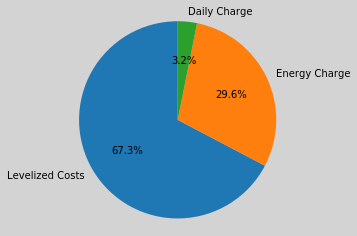

ERROR:ga_logger:panel values: (264.22277890774745, 261.82384335802476, 263.3567311702063, 1.1236864641404605, 1.8810081389125317, 1.833762241557412, 0.20081587542709234, 0.8908451417085379, 0.2079157246398471)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.1
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.57275915145874 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 1.9
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.9667370319366455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 1.8
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.037086009979248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 286 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 276.08068707506567, 60.05707052343994]


ERROR:ga_logger:Cost: 3471.6438512460772


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


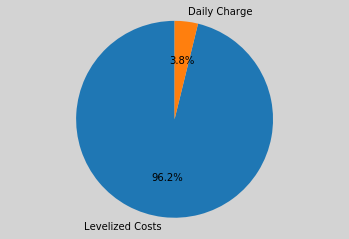

ERROR:ga_logger:panel values: (262.2376783191087, 91.044478625003, 179.06129595861603, 2.3564712914317436, 49.03376631334372, 54.44832050795098, 0.22718096992283637, 0.21418489303122704, 0.20143013997781423)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 2.4
                                           and a gcr of 0.227


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.8160223960876465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 49.0
                                           and a gcr of 0.214


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.326357126235962 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 54.4
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.319858551025391 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 296 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 120.60864925350889]


ERROR:ga_logger:Cost: 6007.790863798251


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


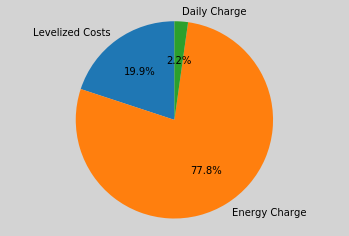

ERROR:ga_logger:panel values: (211.84893702372744, 93.54043103154119, 260.0822641043842, 52.65596952262794, 1.5016958696546614, 9.498738293260983, 0.2060079713860079, 0.2149071078213031, 0.2026506604350076)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 52.7
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2853312492370605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 94
                                           a tilt of 1.5
                                           and a gcr of 0.215


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.199421405792236 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 9.5
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.350224018096924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 305 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [123.34967928360247, 0.0, 0.0]


ERROR:ga_logger:Cost: 6072.234980031699


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


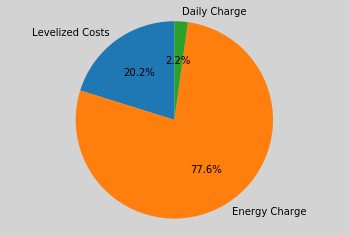

ERROR:ga_logger:panel values: (264.8998117785327, 259.92132647201583, 139.7785560932746, 35.36199853565666, 33.354477600108005, 54.4249516158059, 0.4796405680069282, 0.33150652000821634, 0.47208814809476124)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 35.4
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.545370101928711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 33.4
                                           and a gcr of 0.332


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.41400671005249 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 54.4
                                           and a gcr of 0.472


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.250544548034668 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 297 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 282.6682932187606]


ERROR:ga_logger:Cost: 4203.4106604272665


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


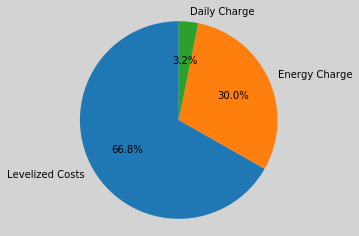

ERROR:ga_logger:panel values: (264.45705908322236, 232.06670885939414, 158.56899898383708, 40.64023794631555, 38.15102787640807, 45.46933960810171, 0.5869835051134814, 0.21727451475382578, 0.3626051232351503)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 40.6
                                           and a gcr of 0.587


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.410984516143799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 232
                                           a tilt of 38.2
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2128894329071045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 45.5
                                           and a gcr of 0.363


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.325144052505493 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 311 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 217.11405319280777]


ERROR:ga_logger:Cost: 4473.946509504274


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


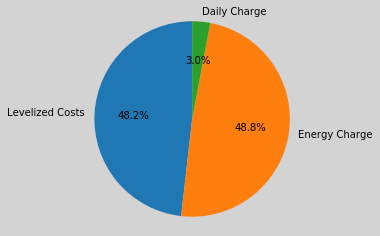

ERROR:ga_logger:panel values: (90.00000000002942, 90.00000000003845, 109.45270866537044, 42.3974246794124, 1.0000000000269471, 15.917170015608878, 0.20000000000013782, 0.8999999999998924, 0.20000000000007173)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 42.4
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.441052198410034 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.594630241394043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 15.9
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.050923824310303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 300 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 275.17269385515806, 58.60284871269268]


ERROR:ga_logger:Cost: 3448.181860038451


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


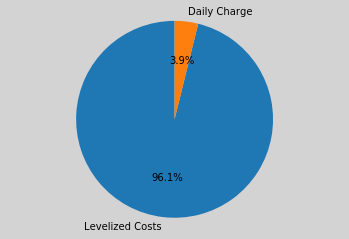

ERROR:ga_logger:panel values: (265.0, 260.9251650210609, 136.83204742118875, 36.894911419427075, 34.26749980064588, 54.036135907979485, 0.4801388075821297, 0.33083841380335544, 0.4771739876770383)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 36.9
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.361356019973755 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 34.3
                                           and a gcr of 0.331


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.426520824432373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 54.0
                                           and a gcr of 0.477


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.2965567111969 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  31 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 336 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 285.71349907660675]


ERROR:ga_logger:Cost: 4227.103591337366


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


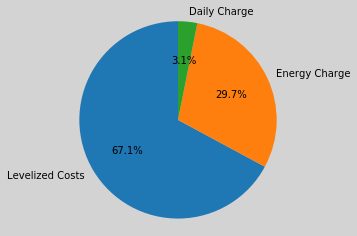

ERROR:ga_logger:panel values: (265.0, 263.02686450139714, 139.95803448350813, 36.577306278401046, 35.4208842086607, 54.23872994351816, 0.4830315953847682, 0.34283199718714297, 0.4705211479765743)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 36.6
                                           and a gcr of 0.483


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.220713138580322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 35.4
                                           and a gcr of 0.343


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.315124034881592 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 54.2
                                           and a gcr of 0.471


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.458148956298828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 354 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 281.73003359344887]


ERROR:ga_logger:Cost: 4200.97782512342


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


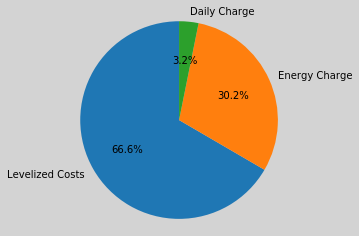

ERROR:ga_logger:panel values: (256.6974928111002, 254.81922171953505, 136.37711977638767, 38.21263535377451, 33.3632416294951, 53.944937715572536, 0.45657719308565137, 0.36536251778936557, 0.447264094831509)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 257
                                           a tilt of 38.2
                                           and a gcr of 0.457


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.719220161437988 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 33.4
                                           and a gcr of 0.365


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.177563190460205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 136
                                           a tilt of 53.9
                                           and a gcr of 0.447


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.431758403778076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 340 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 267.80460135285176]


ERROR:ga_logger:Cost: 4411.570736785244


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


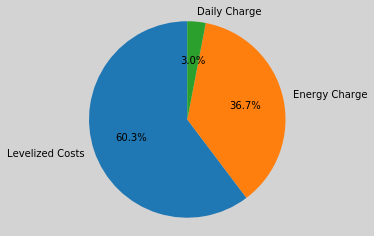

ERROR:ga_logger:panel values: (265.0, 258.6376087619687, 136.872865352156, 36.67627369446934, 34.54668271742722, 54.6347359092105, 0.4869139038393435, 0.3363357359552119, 0.47982794859826333)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 36.7
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.978137493133545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 34.5
                                           and a gcr of 0.336


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.537616014480591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 54.6
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.453282117843628 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 348 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [6.666733334000007e-06, 0.0, 287.3025826102158]


ERROR:ga_logger:Cost: 4235.596850029087


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


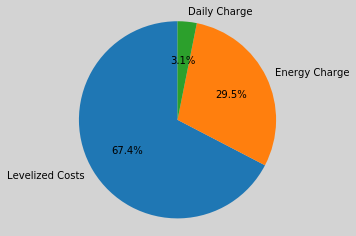

ERROR:ga_logger:panel values: (265.0, 260.8760181203264, 138.10952917829076, 37.1252842799838, 34.028106334957705, 54.57743825729673, 0.4852296698639535, 0.33349090374148904, 0.4760248303098893)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 37.1
                                           and a gcr of 0.485


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.583733797073364 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 34.0
                                           and a gcr of 0.333


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.347606897354126 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 138
                                           a tilt of 54.6
                                           and a gcr of 0.476


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.383994102478027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 369 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 285.0254276798136]


ERROR:ga_logger:Cost: 4226.019901545349


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


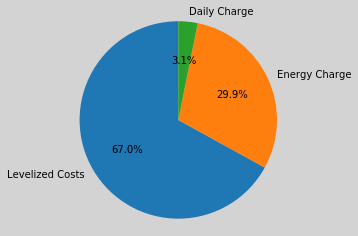

ERROR:ga_logger:panel values: (263.9474659573708, 239.92262022429495, 262.8254402262291, 1.6137515962388496, 1.1838030754384845, 55.849182534663036, 0.8928153922835849, 0.21240174288992933, 0.20287989613351434)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.6
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.681889057159424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 1.2
                                           and a gcr of 0.212


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.20113468170166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 55.8
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.4438817501068115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 369 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [274.0152010058737, 61.98951337698561, 0.0]


ERROR:ga_logger:Cost: 3470.3224394090666


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


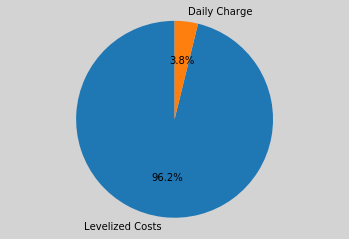

ERROR:ga_logger:panel values: (158.3561386695647, 100.76850649841043, 171.04407790305854, 1.279778038979988, 2.7564686058187657, 5.089923120161662, 0.8607427824209959, 0.20083123311388615, 0.21259375485386156)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 1.3
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.491821765899658 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 101
                                           a tilt of 2.8
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.354015111923218 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 5.1
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.579575538635254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 367 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [270.11044425920096, 0.0, 60.57876219056807]


ERROR:ga_logger:Cost: 3417.5277530517697


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


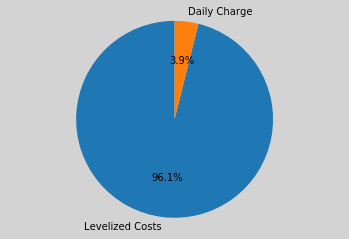

ERROR:ga_logger:panel values: (261.9011109488394, 162.77418165468208, 184.20350909937213, 23.833611443829167, 1.5140212493856433, 55.65139025083458, 0.47514234134921274, 0.2043837176704722, 0.20122825888183665)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 23.8
                                           and a gcr of 0.475


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.604665279388428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 1.5
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.119257211685181 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 55.7
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.826164245605469 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 350 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [284.4970271066156, 0.0, 0.0]


ERROR:ga_logger:Cost: 4388.876825994739


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


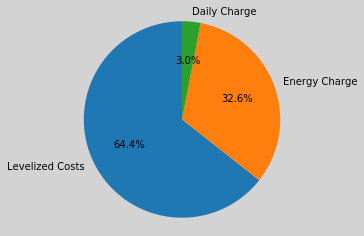

ERROR:ga_logger:panel values: (263.6942593987113, 249.34662262536378, 145.1658952497416, 33.55503734468978, 36.91099177045891, 55.893727326678516, 0.4947105102996352, 0.32125257427536225, 0.4883821742099602)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 33.6
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.205146789550781 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 249
                                           a tilt of 36.9
                                           and a gcr of 0.321


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.476606607437134 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 55.9
                                           and a gcr of 0.488


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.416636943817139 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 352 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 292.4245316881352]


ERROR:ga_logger:Cost: 4048.3297296406454


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


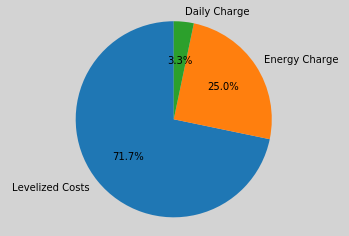

ERROR:ga_logger:panel values: (264.1562197111494, 230.93544490829788, 110.2961360197701, 45.30409081882831, 43.18176783205818, 55.2730803107534, 0.38124491437372743, 0.22085803403784307, 0.5944494898721574)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 45.3
                                           and a gcr of 0.381


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.093176364898682 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 231
                                           a tilt of 43.2
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.767300367355347 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 55.3
                                           and a gcr of 0.594


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.667797803878784 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 346 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 355.9335759324942]


ERROR:ga_logger:Cost: 4644.214161402791


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


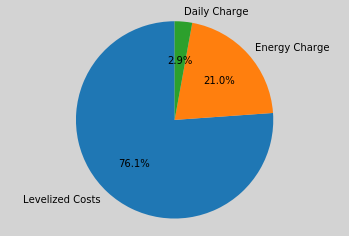

ERROR:ga_logger:panel values: (222.36184340232103, 264.9999999931209, 264.9999999920982, 55.999999999947505, 55.9999999921889, 1.0000000002830465, 0.20000000001267196, 0.8999999999900767, 0.8999999999874746)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 222
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.966626882553101 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.219325542449951 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.747407913208008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 342 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [58.215366960164594, 0.0, 276.91636175331774]


ERROR:ga_logger:Cost: 3461.6517761407304


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


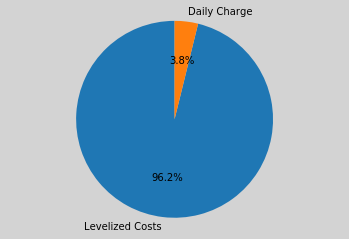

ERROR:ga_logger:panel values: (263.2591584862166, 106.59414149646227, 95.60676764390712, 55.62466536948148, 25.79217607656349, 54.81224850103425, 0.22014709249337577, 0.20066835596688704, 0.20406229527994346)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 55.6
                                           and a gcr of 0.220


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.598568916320801 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 107
                                           a tilt of 25.8
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.399662017822266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 54.8
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.382641077041626 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 339 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 120.15252217824218, 0.0]


ERROR:ga_logger:Cost: 6230.062673380691


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


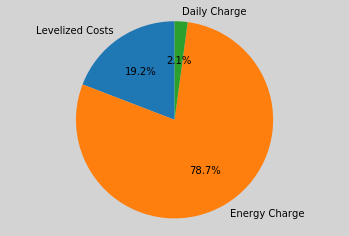

ERROR:ga_logger:panel values: (259.8783804382848, 164.00575130296704, 262.4356484237878, 21.945003716099848, 1.0370150088702426, 33.146485000180206, 0.2534972861513065, 0.23403974391616555, 0.21817240581003003)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 21.9
                                           and a gcr of 0.253


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.362284183502197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 1.0
                                           and a gcr of 0.234


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.793720006942749 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 33.1
                                           and a gcr of 0.218


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.408118963241577 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 341 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [151.78446123063506, 0.0, 0.0]


ERROR:ga_logger:Cost: 5937.0216141994115


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


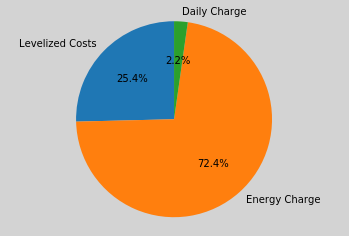

ERROR:ga_logger:panel values: (259.50106212611854, 165.34480228008823, 182.01759241968193, 23.405199693244377, 2.2770258728032218, 55.78071040389116, 0.5238803550452653, 0.20996885547347616, 0.21882638518578504)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 23.4
                                           and a gcr of 0.524


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.494134426116943 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 2.3
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.334868431091309 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 55.8
                                           and a gcr of 0.219


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.453739881515503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 348 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [313.67948212448397, 0.0, 0.0]


ERROR:ga_logger:Cost: 4001.2313468014436


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


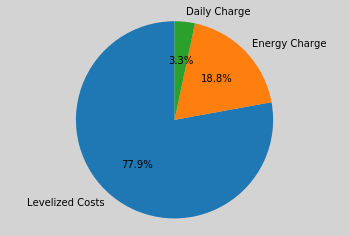

ERROR:ga_logger:panel values: (259.6212874272699, 165.60966962227238, 180.13702243385166, 23.377134135090834, 2.460111003053024, 55.91361251231689, 0.5216391407734224, 0.20899208043246073, 0.2209885288876852)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 23.4
                                           and a gcr of 0.522


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.8891942501068115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 2.5
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.343408584594727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 55.9
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.48765254020691 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  31 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 329 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [312.3375288983698, 0.0, 0.0]


ERROR:ga_logger:Cost: 4017.91489558157


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


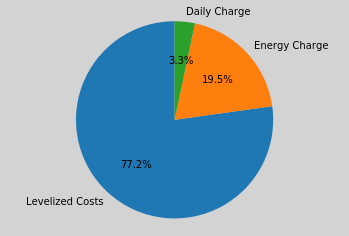

ERROR:ga_logger:panel values: (260.98954060726965, 161.40700819063818, 191.92644195243096, 24.057061250929348, 1.710951942234145, 55.44311807531555, 0.514188741311189, 0.21978796216752802, 0.2005449791525713)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 24.1
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.0499255657196045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 1.7
                                           and a gcr of 0.220


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.09024977684021 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 55.4
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.45563268661499 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 332 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [307.8765151910647, 0.0, 0.0]


ERROR:ga_logger:Cost: 4117.83947933844


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


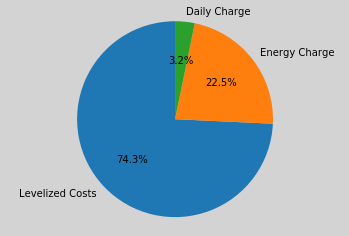

ERROR:ga_logger:panel values: (261.30536833572216, 161.389252688735, 198.2844645498651, 24.45863493554709, 1.102832135039945, 55.506975466784894, 0.5160488468148682, 0.22392698375395825, 0.2000259811364414)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 24.5
                                           and a gcr of 0.516


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.96181321144104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 1.1
                                           and a gcr of 0.224


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.846419811248779 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 55.5
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.517200231552124 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 329 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [308.9902750895726, 0.0, 0.0]


ERROR:ga_logger:Cost: 4125.137893312963


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


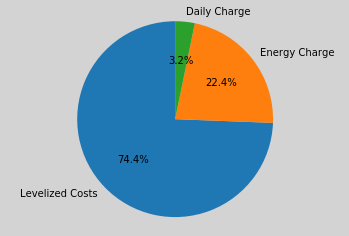

ERROR:ga_logger:panel values: (263.0776687632341, 223.18864010902018, 92.618684796515, 5.4636149794015045, 7.288343224517144, 1.527152313736738, 0.39918110318162975, 0.22927894196858092, 0.22452872462957207)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 5.5
                                           and a gcr of 0.399


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.644311904907227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 223
                                           a tilt of 7.3
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.49859881401062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 1.5
                                           and a gcr of 0.225


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.265024185180664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 328 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [239.0143484363014, 0.0, 0.0]


ERROR:ga_logger:Cost: 4746.301974460381


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


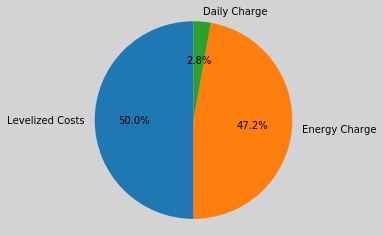

ERROR:ga_logger:panel values: (263.927214809052, 237.90394657408504, 90.41841447240354, 29.581232065760812, 53.83632064043848, 9.664391076310936, 0.20752438971845505, 0.22333386919135517, 0.23894266387339097)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 29.6
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.283909797668457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 53.8
                                           and a gcr of 0.223


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.736328125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 9.7
                                           and a gcr of 0.239


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.719569206237793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 315 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 143.0697111263789]


ERROR:ga_logger:Cost: 5995.581456441844


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


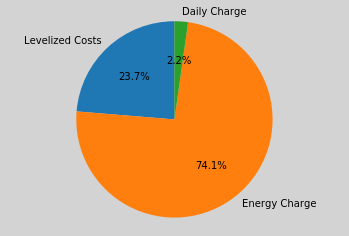

ERROR:ga_logger:panel values: (262.77724202061484, 220.45630647321406, 91.05078647369425, 4.986428476371176, 9.597366653469393, 1.5911392276589666, 0.4116177817704398, 0.20496771020123492, 0.20983619323899008)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 5.0
                                           and a gcr of 0.412


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.55806827545166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 9.6
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.120440244674683 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 1.6
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.4461140632629395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  24 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 313 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [246.4609550160921, 0.0, 0.0]


ERROR:ga_logger:Cost: 4646.276461259375


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


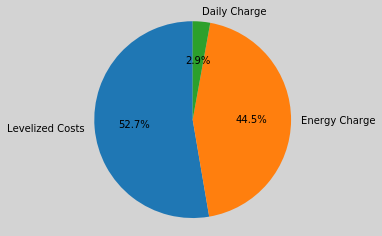

ERROR:ga_logger:panel values: (262.8711782118263, 217.27658520591336, 90.03385740237621, 4.122522248753675, 11.454239743817913, 1.5748212517969846, 0.41838884087030537, 0.20454778434036888, 0.2004154498406654)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 4.1
                                           and a gcr of 0.418


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.161492347717285 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 11.5
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.110720157623291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.452399015426636 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 318 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [250.5152057465939, 0.0, 0.0]


ERROR:ga_logger:Cost: 4592.101569253954


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


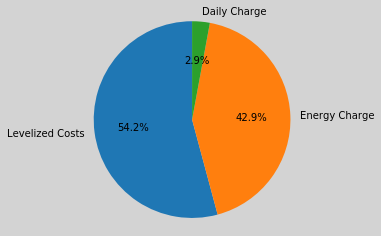

ERROR:ga_logger:panel values: (262.79913678516243, 217.84955823411062, 90.49625368869104, 4.2025608801502035, 11.535716064316318, 1.6509042620197245, 0.41937191669234963, 0.2022767083104633, 0.20166509034505897)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 4.2
                                           and a gcr of 0.419


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.173556327819824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 218
                                           a tilt of 11.5
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.644188642501831 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.7
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.3609230518341064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 308 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [251.10383387850328, 0.0, 0.0]


ERROR:ga_logger:Cost: 4584.210705272004


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


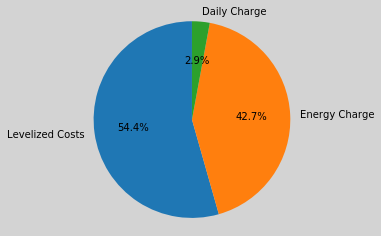

ERROR:ga_logger:panel values: (263.9832476040807, 215.42666129565436, 90.83401005000664, 4.083852064318005, 11.894589975211185, 1.4259543823150467, 0.4144548082895322, 0.2059258106653227, 0.20082813585585396)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 4.1
                                           and a gcr of 0.414


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.910302639007568 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 11.9
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.724128484725952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 1.4
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.341196775436401 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  24 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 317 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [248.15965778495786, 0.0, 0.0]


ERROR:ga_logger:Cost: 4626.926175521682


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


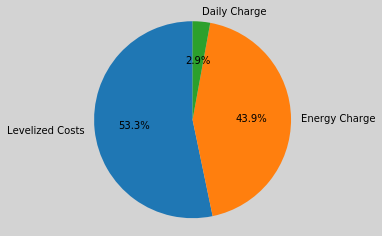

ERROR:ga_logger:panel values: (262.80969438592695, 217.29121152748075, 90.05641047818987, 4.118636162254875, 11.449865287555161, 1.5764307853757344, 0.418133837158268, 0.20451922448947357, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 4.1
                                           and a gcr of 0.418


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.351315498352051 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 11.4
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.5511860847473145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2524378299713135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 314 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [250.36251929490325, 0.0, 0.0]


ERROR:ga_logger:Cost: 4593.877725720108


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


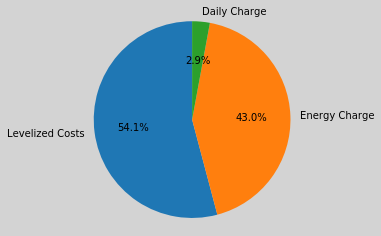

ERROR:ga_logger:panel values: (262.95612149284796, 217.26923102921288, 90.0, 4.148219454962234, 11.453265484842182, 1.5658020234086036, 0.41881236571219166, 0.2046842755894997, 0.2004092508443813)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 4.1
                                           and a gcr of 0.419


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.481200695037842 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 11.5
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.34260892868042 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.387380361557007 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 338 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [250.7687961931864, 0.0, 0.0]


ERROR:ga_logger:Cost: 4589.115607349344


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


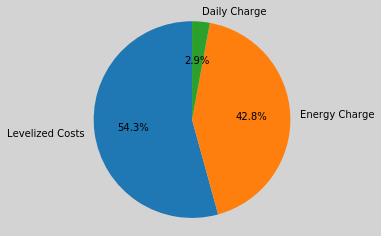

ERROR:ga_logger:panel values: (262.85845822324416, 217.2594155684889, 90.0, 4.117779814484349, 11.454685171735395, 1.5804097769439298, 0.4183500107162281, 0.20449192235982183, 0.20062035262650912)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 4.1
                                           and a gcr of 0.418


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.348174333572388 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 11.5
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.781299591064453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.6
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.310605049133301 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  25 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 322 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [250.4919557384136, 0.0, 0.0]


ERROR:ga_logger:Cost: 4592.35494063676


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


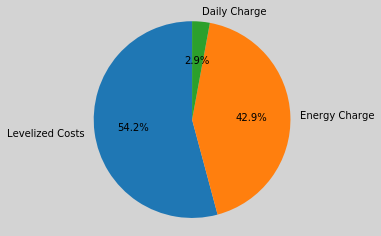

ERROR:ga_logger:panel values: (262.24683377720777, 217.61079356862803, 90.0276162756177, 4.11225821404584, 11.549130248285033, 1.0, 0.41844324814089373, 0.2044418961697777, 0.2019049863653659)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 4.1
                                           and a gcr of 0.418


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.676860809326172 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 218
                                           a tilt of 11.5
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.493834733963013 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.202


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.502281904220581 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 314 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [250.5477827349059, 0.0, 0.0]


ERROR:ga_logger:Cost: 4589.402109785806


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


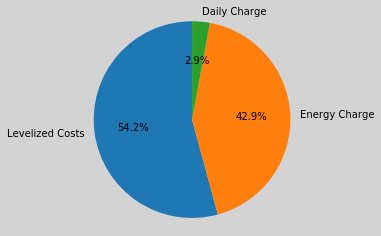

ERROR:ga_logger:panel values: (262.96434681864173, 217.35362017939477, 90.0, 4.103924017517469, 11.458073931362081, 1.569570301071077, 0.4182296154305779, 0.20449248155123012, 0.20036059739503484)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 4.1
                                           and a gcr of 0.418


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.786992073059082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 11.5
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.273012399673462 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.6
                                           and a gcr of 0.200


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.081987380981445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 314 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [250.41986765458813, 0.0, 0.0]


ERROR:ga_logger:Cost: 4593.66706650661


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


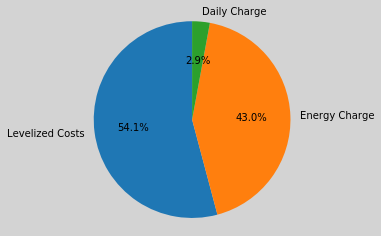

ERROR:ga_logger:panel values: (261.88336997377803, 253.03722520636575, 90.2211526716069, 2.1096260371313003, 53.60572693960246, 1.407941508631105, 0.8973373306022188, 0.20352731929366466, 0.8614723054781439)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 2.1
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.798171758651733 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 53.6
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2812278270721436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.4
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.180335521697998 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 321 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.8645637334283]


ERROR:ga_logger:Cost: 3468.930435129152


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


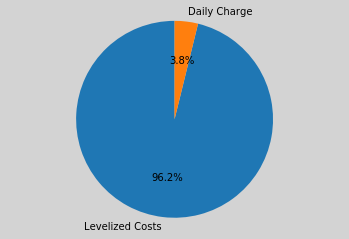

ERROR:ga_logger:panel values: (264.4592570937631, 264.1016930321562, 90.29849990397886, 1.517147492411933, 55.20226971593254, 1.446266183814747, 0.8956524592077346, 0.2039624894939798, 0.32775263710099195)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.5
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.641722679138184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 55.2
                                           and a gcr of 0.204


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.031819820404053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.4
                                           and a gcr of 0.328


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.0914952754974365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 348 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [220.53596094062766, 0.0, 115.54338727110587]


ERROR:ga_logger:Cost: 3471.0637174676162


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


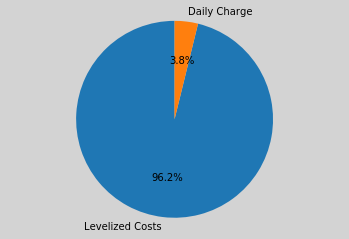

ERROR:ga_logger:panel values: (263.92141856014064, 255.07484244134645, 90.3534542774521, 1.5252820157535205, 52.786909399348374, 2.0099610200989435, 0.8929513521088932, 0.20994401689811548, 0.8982351911061033)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.5
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.500330209732056 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 52.8
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.263121604919434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 2.0
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.159909009933472 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 320 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.1729613863876]


ERROR:ga_logger:Cost: 3471.993502387432


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


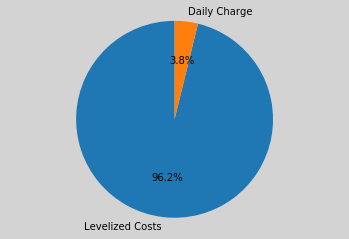

ERROR:ga_logger:panel values: (263.7691860415008, 255.36899054151678, 90.33761305618175, 1.6409250422016584, 52.79927252179589, 1.5243004784597662, 0.8937804600944881, 0.20699710531662885, 0.899294426958511)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.6
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.439090013504028 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 52.8
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.341320991516113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.5
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.655813694000244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 331 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.0131988765847]


ERROR:ga_logger:Cost: 3470.4067091174093


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


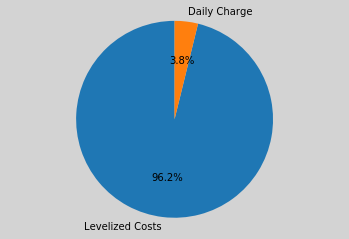

ERROR:ga_logger:panel values: (263.997750030274, 256.02730393278534, 90.91191973554378, 1.6981009842980241, 53.07595904220771, 1.3398106017307831, 0.8974450220167156, 0.2066203276253315, 0.8988580719343815)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.7
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.124361276626587 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 53.1
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.065261602401733 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 1.3
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.106853246688843 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 327 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.9400392521511]


ERROR:ga_logger:Cost: 3469.6800730796467


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


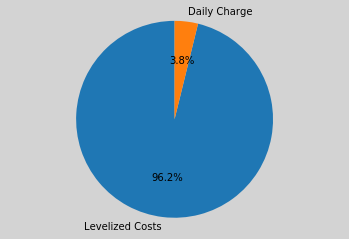

ERROR:ga_logger:panel values: (263.40816708953037, 255.07382308603286, 90.49027676330016, 1.469170844269334, 52.75396616400801, 1.5375367370326045, 0.887281933891809, 0.20496872208796918, 0.8983405704241685)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 1.5
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.040695905685425 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 52.8
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.50407338142395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.5
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.092587471008301 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 328 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.998634756785]


ERROR:ga_logger:Cost: 3470.262055372329


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


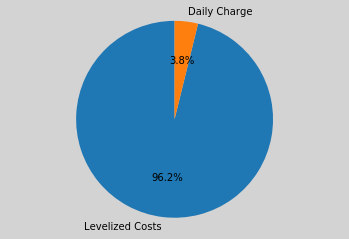

ERROR:ga_logger:panel values: (264.0503559494842, 220.67078133425366, 92.86627644344537, 54.26722964805468, 55.757521311877454, 1.1209022541960303, 0.8996339294275768, 0.8616655089016831, 0.8994549621883705)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 54.3
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.050886869430542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 221
                                           a tilt of 55.8
                                           and a gcr of 0.862


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.054840087890625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 1.1
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.438062429428101 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  19 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 309 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.8238231321363]


ERROR:ga_logger:Cost: 3468.525791329968


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


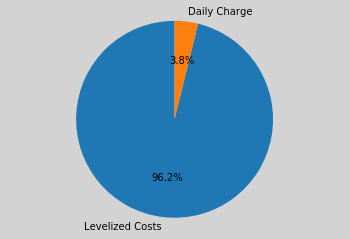

ERROR:ga_logger:panel values: (263.36743434782613, 252.58930048972525, 92.46961543588404, 2.499950554500056, 54.10472510307278, 41.956503407564036, 0.8954083603356879, 0.7585629065978854, 0.889769600387198)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 2.5
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.570241212844849 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 54.1
                                           and a gcr of 0.759


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.188031196594238 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 42.0
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.347731590270996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 292 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [336.6339668416295, 0.0, 0.0]


ERROR:ga_logger:Cost: 3476.57230077453


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


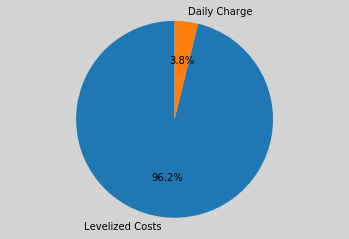

ERROR:ga_logger:panel values: (264.11418373924255, 253.66607265336972, 96.00708096554177, 1.2020325802694922, 55.104448132530855, 23.90456274843748, 0.8865351529550549, 0.4516848523430868, 0.8969238637824617)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.2
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.296722650527954 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 254
                                           a tilt of 55.1
                                           and a gcr of 0.452


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.340207815170288 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 23.9
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.084516763687134 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 282 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [336.22721285199543, 0.0, 0.0]


ERROR:ga_logger:Cost: 3472.5323385869465


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


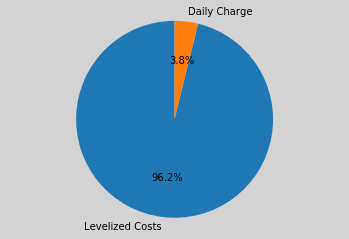

ERROR:ga_logger:panel values: (264.63027886695295, 262.1586399669614, 90.61573071865593, 4.9564652384370955, 55.981753474674456, 10.345185450446307, 0.8998999398034553, 0.3191092546875186, 0.8887681440242423)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 5.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.3367486000061035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 56.0
                                           and a gcr of 0.319


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.215577125549316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 10.3
                                           and a gcr of 0.889


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2148518562316895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 254 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [339.97639012364283, 0.0, 0.0]


ERROR:ga_logger:Cost: 3509.7699174891545


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


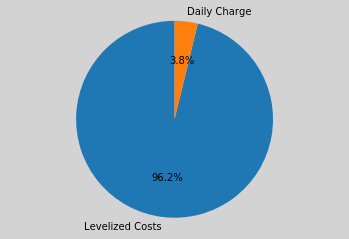

ERROR:ga_logger:panel values: (264.27005313036364, 255.18910022290476, 91.14320065068715, 3.3812809817743195, 53.50963914757004, 3.151735213565028, 0.8988385174790807, 0.23157745281809397, 0.8873842599468182)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 3.4
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.8223395347595215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 53.5
                                           and a gcr of 0.232


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.506133556365967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 3.2
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.391658782958984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 288 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.6773749169791]


ERROR:ga_logger:Cost: 3477.0034386442762


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


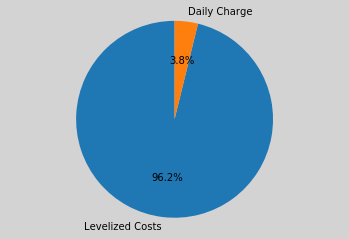

ERROR:ga_logger:panel values: (264.162500552815, 255.47634574442827, 90.16293813846156, 1.633828685814756, 52.85417539956061, 1.713264066764077, 0.8999999999952906, 0.2092912913840564, 0.8989026407957679)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.6
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.834732294082642 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 52.9
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.831568956375122 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.7
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.63024115562439 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 317 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.07560467077064]


ERROR:ga_logger:Cost: 3471.026535970157


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


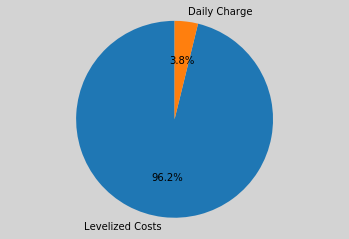

ERROR:ga_logger:panel values: (93.58000050581346, 262.4706285201502, 95.59428722845222, 1.5064542157323975, 55.55574634989252, 55.03006930714371, 0.892432857459547, 0.351021954599006, 0.899508108874264)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 1.5
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.71240496635437 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 55.6
                                           and a gcr of 0.351


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.764707088470459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 55.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.6377341747283936 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  24 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 299 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [335.72469536548533, 0.0, 0.0]


ERROR:ga_logger:Cost: 3467.541234615795


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


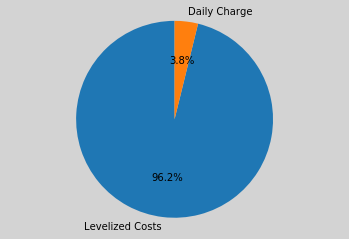

ERROR:ga_logger:panel values: (263.39876083880245, 112.16133834909417, 91.24841900697541, 1.7334460965424605, 55.7417278479352, 9.348738264877444, 0.8979251048516181, 0.8758156688465846, 0.8614743184510694)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 1.7
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.462761640548706 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 55.7
                                           and a gcr of 0.876


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.601100921630859 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 9.3
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.606903553009033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 308 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [336.30161554200515, 0.0, 0.0]


ERROR:ga_logger:Cost: 3473.2713210813645


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


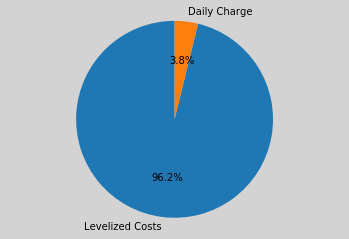

ERROR:ga_logger:panel values: (261.19299925882103, 262.5150153089801, 94.9362329870392, 1.049869049954715, 51.88423450330769, 34.311102405962366, 0.8994045963094146, 0.5937621618559878, 0.8586875438615411)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 1.0
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.884502649307251 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 51.9
                                           and a gcr of 0.594


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.411024332046509 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 34.3
                                           and a gcr of 0.859


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.409535646438599 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  20 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 326 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [336.07266301257727, 0.0, 0.0]


ERROR:ga_logger:Cost: 3470.997318705789


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


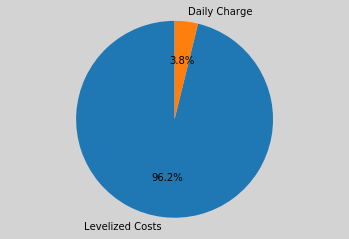

ERROR:ga_logger:panel values: (264.86302468518255, 264.47097322997445, 90.48512503983083, 1.1927585823548907, 55.7873432503985, 10.427959950592939, 0.8995060305191773, 0.3215828158249595, 0.864009869061924)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.2
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.628404140472412 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 55.8
                                           and a gcr of 0.322


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.048110723495483 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 10.4
                                           and a gcr of 0.864


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.242190837860107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  25 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 342 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [336.2895288142677, 0.0, 0.0]


ERROR:ga_logger:Cost: 3473.151273179497


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


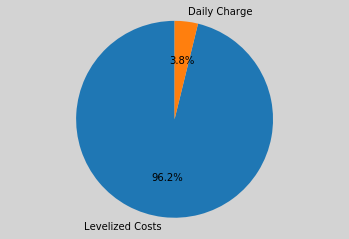

ERROR:ga_logger:panel values: (264.3331664786242, 264.80247772444545, 90.2091760923127, 1.066115144393397, 55.94846619322035, 10.26072904576085, 0.897188481863247, 0.3221473781077596, 0.8639548099048897)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.1
                                           and a gcr of 0.897


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.64519190788269 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 55.9
                                           and a gcr of 0.322


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.6826958656311035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 10.3
                                           and a gcr of 0.864


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.488422632217407 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 328 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [336.2408406634631, 0.0, 0.0]


ERROR:ga_logger:Cost: 3472.6676927205986


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


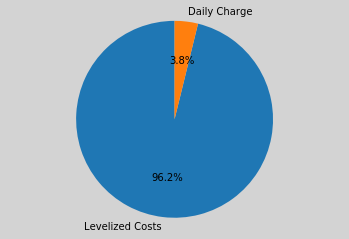

ERROR:ga_logger:panel values: (263.9220024128401, 255.4568544576702, 90.32953230641223, 1.6633780504680606, 52.83473959449977, 1.585860641814483, 0.8960455433515635, 0.2079803981221565, 0.8992120648372286)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.7
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.137252569198608 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 52.8
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.687469720840454 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.6
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2943806648254395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 326 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.02752270063434]


ERROR:ga_logger:Cost: 3470.5489762117263


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


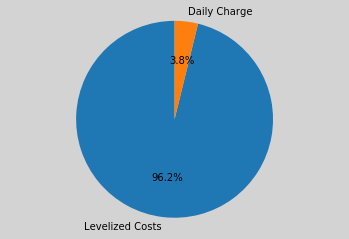

ERROR:ga_logger:panel values: (263.3119247465163, 254.99756352754702, 90.568270470055, 1.593325338203278, 52.83276052440033, 1.4777175011966048, 0.8942546607335469, 0.2081120523632076, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 1.6
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.199548959732056 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 52.8
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.452449560165405 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 1.5
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.3489463329315186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 301 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.9900465539218]


ERROR:ga_logger:Cost: 3470.176755616428


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


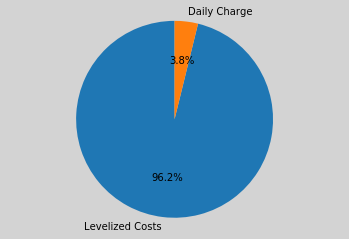

ERROR:ga_logger:panel values: (263.29476015513427, 255.45297359929043, 90.4390680964464, 1.7272438251309827, 52.80445212760257, 1.663591789287254, 0.8944643160409291, 0.20478380986825018, 0.8999744262703961)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 1.7
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.553293943405151 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 52.8
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.453225612640381 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.7
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.141211032867432 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 275 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.04430973157696]


ERROR:ga_logger:Cost: 3470.7157083747243


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


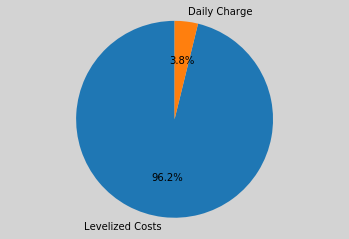

ERROR:ga_logger:panel values: (264.015541706752, 255.046935681463, 90.45437322741267, 1.6710938536701616, 52.82219286632568, 1.530989715251937, 0.8938420980921553, 0.20642537927191168, 0.8996047029681917)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.7
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.34166955947876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 52.8
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.214046239852905 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.5
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.04574728012085 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 272 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.00732125074745]


ERROR:ga_logger:Cost: 3470.34833136577


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


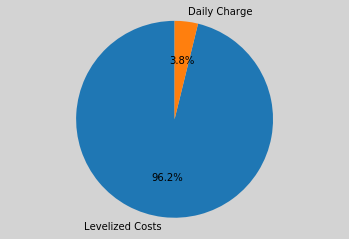

ERROR:ga_logger:panel values: (263.75324181155247, 255.35021200481748, 90.18281364218791, 1.64405490037996, 52.85040636152031, 1.5268901127516261, 0.8936523513719437, 0.20701683102655943, 0.8995011392657535)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.6
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.605161428451538 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 52.9
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.082442760467529 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 1.5
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.080944299697876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  21 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 296 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.02699894536124]


ERROR:ga_logger:Cost: 3470.5437741573205


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


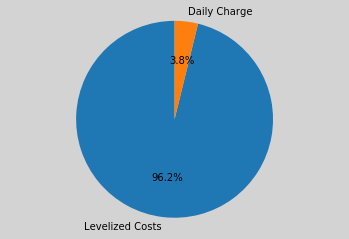

ERROR:ga_logger:panel values: (262.2003128223647, 262.88850125509265, 90.84999839378237, 1.2017110649809077, 1.979825573074598, 50.579691925964724, 0.8936786877414378, 0.8947542356930342, 0.24617104023191178)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 1.2
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.979267358779907 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 2.0
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.826984643936157 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 50.6
                                           and a gcr of 0.246


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.18295431137085 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 316 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [336.1178865372432, 0.0, 0.0]


ERROR:ga_logger:Cost: 3471.4464878022736


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


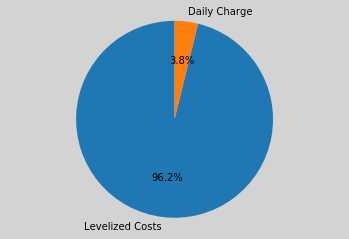

ERROR:ga_logger:panel values: (262.4292896483576, 262.7872523534591, 90.45591823839318, 1.0061540408100869, 1.4636265848600334, 5.405980993977577, 0.8783445999156583, 0.882392195201084, 0.8534895991421807)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 1.0
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.631252765655518 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 1.5
                                           and a gcr of 0.882


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.748605966567993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 5.4
                                           and a gcr of 0.853


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.317744255065918 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  19 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 328 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [336.1261529088156, 0.0, 0.0]


ERROR:ga_logger:Cost: 3471.5285910180423


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


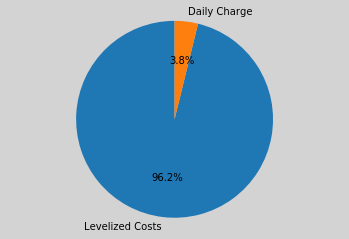

ERROR:ga_logger:panel values: (263.8892494009428, 262.47280758028273, 94.40180302310696, 1.3605978188475323, 14.958454411547823, 44.899456001149204, 0.8865370769130141, 0.8928295977556684, 0.7522442674080225)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 1.4
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.440985918045044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 15.0
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.243861436843872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 44.9
                                           and a gcr of 0.752


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.501098155975342 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  23 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 333 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [336.2278194321136, 0.0, 0.0]


ERROR:ga_logger:Cost: 3472.5383632870958


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.0424999999616


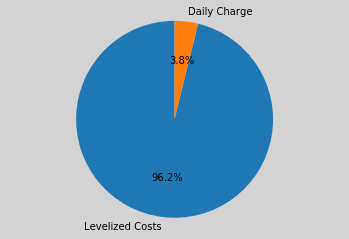

ERROR:ga_logger:panel values: (264.86946788394414, 264.4173606947206, 90.09858270862532, 1.0199420427220802, 4.786427699717843, 14.216563130277086, 0.8969867142961754, 0.8948283007102364, 0.8334167232017733)


In [28]:
# Bonmin path
BONMIN_PATH = "/home/theochri/projects/def-revins/theochri/Bonmin/bonmin"

# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10 )
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i+number_of_opt_evaluations)+10)
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost-true"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE", bonmin_path=BONMIN_PATH, rand_seed =int(run_i)+10)
    pvoptimizer.processGA(ga_fina)

